# 경제 분석 및 예측과 데이터 지능 실습3: Vector AutoRegression Basics

OECD데이터를 활용해 VAR 분석을 실습합니다. Statsmodels을 주로 다루고, 실제 데이터에 적용해 봅니다.

References:
- [Vector Autoregression with Statsmodels](https://www.statsmodels.org/stable/vector_ar.html)
- [Sims (1986, FRB of Minneapolis)](https://www.minneapolisfed.org/research/quarterly-review/are-forecasting-models-usable-for-policy-analysis)
- [Blanchard and Quah (1989, AER)](https://uh.edu/~bsorense/BlanchardQuah1989.pdf)

## oecddatabuilder 패키지 소개

- oecddatabuilder 패키지는 OECD data explorer UI(user interface)를 통해 다운로드 하는 것이 불가능한 대용량 API를 처리하려는 목적에서 개발되었습니다.
- recipe, builder의 두 클래스로 이루어 지며 원하는 분석 데이터를 recipe에 저장해 두면 추후에 다른 국가, 다른 기간으로 동일한 데이터를 반복해서 다운로드 할 수 있습니다.
- 데이터의 양이 많은 경우에 latency 조절, 트래픽 조절을 통해 block당하지 않도록 유의해야 합니다.

In [1]:
import pandas as pd
import numpy as np
import oecddatabuilder as oecd

In [2]:
oecd.test_api_connection() # 연결을 테스트 합니다.

INFO:oecddatabuilder.utils:API connection successful.


### Recipe

In [3]:
loader = oecd.RecipeLoader()

In [4]:
recipe = loader.load("DEFAULT")

INFO:oecddatabuilder.recipe_loader:User configuration merged for group 'DEFAULT'.


In [5]:
builder = oecd.OECDAPI_Databuilder(config=recipe, start="1990-Q1", end = "2024-Q4", freq = "Q",
                                   base_url="https://sdmx.oecd.org/public/rest/data/OECD.SDD.NAD,DSD_NAMAIN1@DF_QNA,1.1/",
                                   request_interval=30)

INFO:oecddatabuilder.databuilder:Combined countries from configuration: ['CAN', 'CHN', 'DEU', 'FRA', 'GBR', 'IND', 'IRL', 'ITA', 'JPN', 'KOR', 'MEX', 'USA']


### Recipe기준으로 데이터를 가져옵니다.

- 보통 호출 간격을 30초, chunk size를 100 정도 하면 10분내에 12개국의 1500행정도 데이터를 받을 수 있습니다.
- 더 자주, 더 많은 데이터를 가져올 수도 있으나 중간에 block 되어 데이터 일부를 받지 못하는 점을 방지하기 위해 안정적인 값을 설정하는 것이 좋습니다.

In [6]:
# builder.fetch_data(chunk_size=100)

INFO:oecddatabuilder.databuilder:For indicator 'Y', processing time chunks: [('1990-Q1', '2014-Q4'), ('2015-Q1', '2024-Q4')]
INFO:oecddatabuilder.databuilder:Fetching data for 'Y' using URL: https://sdmx.oecd.org/public/rest/data/OECD.SDD.NAD,DSD_NAMAIN1@DF_QNA,1.1/Q..KOR+CAN+USA+CHN+GBR+DEU+FRA+JPN+ITA+IND+MEX+IRL.S1..B1GQ....USD_PPP.LR..
INFO:oecddatabuilder.databuilder:Data for indicator 'Y' saved to /Users/minkeychang/forecasting/practices/datasets/OECD/Y.csv
INFO:oecddatabuilder.databuilder:For indicator 'C', processing time chunks: [('1990-Q1', '2014-Q4'), ('2015-Q1', '2024-Q4')]
INFO:oecddatabuilder.databuilder:Fetching data for 'C' using URL: https://sdmx.oecd.org/public/rest/data/OECD.SDD.NAD,DSD_NAMAIN1@DF_QNA,1.1/Q..KOR+CAN+USA+CHN+GBR+DEU+FRA+JPN+ITA+IND+MEX+IRL.S1M..P3....USD_PPP.LR..
INFO:oecddatabuilder.databuilder:Data for indicator 'C' saved to /Users/minkeychang/forecasting/practices/datasets/OECD/C.csv
INFO:oecddatabuilder.databuilder:For indicator 'G', processing ti

In [7]:
df = builder.create_dataframe()
df.to_csv("../datasets/querterly_oecd_account_data.csv", index=False)
df.head()

,country,date,Y,C,G,I,EX,IM
0,CAN,1990-01-01,1015714.7,518707.4,271355.6,223461.1,207736.8,200021.9
1,DEU,1990-01-01,3220806.5,1811014.8,569128.8,725261.2,527153.8,489620.3
2,FRA,1990-01-01,2244890.8,1170205.4,554966.9,517196.6,352329.9,353194.4
3,GBR,1990-01-01,2038060.5,1141647.3,450827.1,404835.9,345478.9,331416.2
4,IRL,1990-01-01,99243.7,47489.0,21623.8,23005.3,29526.0,33508.4


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

In [7]:
df = pd.read_csv("../datasets/querterly_oecd_account_data.csv")
countries = df["country"].unique()
print(countries)

['CAN' 'DEU' 'FRA' 'GBR' 'IRL' 'ITA' 'JPN' 'KOR' 'MEX' 'USA' 'IND']


## 벡터 자기회귀 모형(Vector AutoRegression, VAR)

- SUR(Seemingly Unrelated Regression) 하에서 GLS와 OS는 $x_{1t} = x_{2t}$인 경우에 같습니다.
- 따라서 VAR 모형은 OLS(최소제곱법)로 추정이 가능합니다.
- 소득과 소비를 VAR(2) 모형으로 표현해 보면 다음과 같습니다:

$$
\begin{bmatrix}
c_{t} \\
y_{t}
\end{bmatrix}
=
\begin{bmatrix}
u_{1} \\
u_{2}
\end{bmatrix}
+
\begin{bmatrix}
\phi_{11}(1) & \phi_{12}(1) \\
\phi_{21}(1) & \phi_{22}(1)
\end{bmatrix}
\begin{bmatrix}
c_{t-1} \\
y_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
\phi_{11}(2) & \phi_{12}(2) \\
\phi_{21}(2) & \phi_{22}(2)
\end{bmatrix}
\begin{bmatrix}
c_{t-2} \\
y_{t-2}
\end{bmatrix}
+
\begin{bmatrix}
\epsilon_{1t} \\
\epsilon_{2t}
\end{bmatrix}
$$
또는
$$
\bold{X}_{t} = \mu + \Phi(1) \bold{X}_{t-1} + \Phi(2) \bold{X}_{t-2} + \Epsilon_{t}
$$

- 여기서 잔차항은 $\Epsilon_{t} \sim N(0, \Omega)$ 를 따르는 벡터입니다.
- 위 모형이 성립하려면 $| I - \Phi(1)Z - \Phi(2)Z^{2} | = 0$ 의 모든 해(solution)의 절대값이 1보다 커야 합니다.
- 이러한 정상성(stationarity) 가정은 eigenvalue(고유값)의 가장 큰 값이 1보다 작다는 말과 동일합니다.



### Lag Length(시차 길이)

1. **Lag Length 결정의 중요성:**
   - VAR 모형의 시차(lag) 길이는 모형의 설명력과 예측 성능에 크게 영향을 미칩니다.
   - 너무 짧은 시차를 선택하면 모형에 중요한 동적 정보를 반영하지 못하고, 너무 긴 시차를 선택하면 모형 복잡성이 증가하고 불필요한 파라미터가 포함됩니다.

2. **통계적 검정 방법:**
   - **Wald Test(F-test):** 
     - F 통계량:
       $$
       F = \frac{(|\hat{\Omega}(H_{0})| - |\hat{\Omega}(H_{1})|) / J}{|\hat{\Omega}(H_{1})| / (T-k)}
       $$
   - **Likelihood Ratio Test(LR Test):** 
     - LR 통계량:
       $$
       LR = (T-k) \left( \log |\hat{\Omega}(H_{0})| - \log |\hat{\Omega}(H_{1})| \right) \sim \chi^{2}(J)
       $$
       - 여기서 $\hat{\Omega}(H_{0}) = \sum \hat{\epsilon}_{t}(H_{0})\hat{\epsilon}_{t}(H_{0})'$, $\hat{\Omega}(H_{1}) = \sum \hat{\epsilon}_{t}(H_{1})\hat{\epsilon}_{t}(H_{1})'$ 는 잔차 공분산 행렬을 의미합니다.
       - T는 표본 크기, k는 추정된 파라미터의 수, 그리고 J는 제약 조건의 수를 의미합니다.
       - 또한 $\hat{\epsilon}_{t} = \bold{X}_{t} - \hat{\mu} - \Phi(1) \bold{X}_{t-1} - \Phi(2) \bold{X}_{t-2} $ 이고 가설에 따라 $\Phi(1)$ 또는 $\Phi(2)$ 가 0이 됩니다.

3. **순차적 검정 방법(Sequential Test):**
   - 시차 길이 결정을 위해 순차적 검정 방법을 사용하여, 한 단계씩 추가하면서 모형의 적합도를 평가합니다.
   - 각 단계에서 추가된 시차가 통계적으로 유의한지 여부를 평가하고, 유의하지 않은 경우 시차 길이를 결정하게 됩니다.
   - 이러한 검정 방법은 Wald test나 LR test를 기반으로 하며, 큰 표본에서는 두 검정의 결과가 동일하게 나타나는 경향이 있습니다.
   - 예를 들어, LR 검정 통계량과 J * F (F 통계량을 chi-square 분포로 변환한 통계량)은 큰 표본 환경에서 동등한 결과를 보입니다.


### Granger Causality Test

   - 위 모형에서 y가 c를 GC(Granger Cause)하지 '않는다'는 다음과 같이 검정할 수 있습니다.
   $$
   H_{0} : \phi_{12}(1) =\phi_{12}(2) = 0
   $$

   - 마찬가지로, c가 y를 GC하지 '않는다'는 것은 다음과 같이 검정합니다.
   $$
   H_{0} : \phi_{21}(1) =\phi_{21}(2) = 0
   $$

   - Test statistic은 아래와 같습니다.
   $$
   F = \frac{(RSS_{0} - RSS_{1})/J}{RSS_{1}/(T-k)} \quad \sim \quad F(T-k)
   $$




##### 실습 코드는 아래와 같습니다.

In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR

# -------------------------------------------------------------------
# 1. 데이터 불러오기 및 전처리
# -------------------------------------------------------------------
selected_country = 'KOR'
df_country = df[df["country"] == selected_country].copy()

# 날짜 변환 및 인덱스 설정
df_country['date'] = pd.to_datetime(df_country['date'])
df_country.set_index('date', inplace=True)

# 주어진 데이터가 분기(quarterly) 데이터임을 명시적으로 설정
df_country = df_country.asfreq('QS')

# VAR 분석에 사용할 변수 선택: 소득(Y)와 소비(C)
data = df_country[['Y', 'C']]

# -------------------------------------------------------------------
# 2. VAR 모형 적합 및 시차 선택
# -------------------------------------------------------------------
# VAR 모형 생성
model = VAR(data)

# 최대 시차(maxlags)를 8로 지정하여 각 정보 기준에 따른 최적 시차 선택 결과 확인
lag_order_res = model.select_order(maxlags=10)
print("시차 선택 결과 (Lag Order Selection):")
print(lag_order_res.summary())

# 예시: 최적 시차 길이를 2로 선택 (실제 최적 시차는 선택 결과에 따라 달라질 수 있음)
optimal_lag = 7

# VAR(2) 모형 적합
results = model.fit(optimal_lag)
print(results.summary())

# 모형의 안정성(정상성) 확인: 모든 고유값의 절대값이 1보다 작아야 정상성을 만족
print("모형의 고유값 (Eigenvalues):", results.roots)


시차 선택 결과 (Lag Order Selection):
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        46.73       46.78   1.972e+20       46.75
1        38.17       38.30   3.776e+16       38.22
2        38.04      38.26*   3.326e+16      38.13*
3        38.06       38.37   3.380e+16       38.18
4        38.05       38.45   3.344e+16       38.21
5        38.05       38.54   3.362e+16       38.25
6        38.05       38.62   3.337e+16       38.28
7       38.04*       38.70  3.326e+16*       38.31
8        38.05       38.80   3.350e+16       38.35
9        38.07       38.91   3.424e+16       38.41
10       38.08       39.00   3.459e+16       38.45
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 13, Apr, 2025
Time:                     21:31:21
----------------------------

##### 이제 로그 1차 차분을 하고 다시 분석을 수행해 보겠습니다.

In [12]:
# -------------------------------------------------------------------
# 1. 로그 변환 및 1차 차분 적용
# -------------------------------------------------------------------
# 로그 변환: 데이터의 multiplicative 효과를 additive 효과로 변환
data_log = np.log(data)

# 로그 1차 차분: 성장률(상대 변화)을 계산, small changes에 대해 (X_t - X_(t-1)) / X_(t-1) 로 근사됨
data_log_diff = data_log.diff().dropna()

# -------------------------------------------------------------------
# 2. VAR 모형 적합 및 시차 선택
# -------------------------------------------------------------------
# VAR 모형 생성 (로그 1차 차분된 데이터를 사용)
model = VAR(data_log_diff)

# 최대 시차(maxlags)를 8로 지정하여 각 정보 기준에 따른 최적 시차 선택 결과 확인
lag_order_res = model.select_order(maxlags=8)
print("시차 선택 결과 (Lag Order Selection):")
print(lag_order_res.summary())

시차 선택 결과 (Lag Order Selection):
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -17.63      -17.58   2.212e-08      -17.61
1     -17.82*     -17.69*  1.817e-08*     -17.77*
2      -17.77      -17.55   1.920e-08      -17.68
3      -17.73      -17.42   1.991e-08      -17.61
4      -17.69      -17.29   2.086e-08      -17.53
5      -17.71      -17.23   2.041e-08      -17.51
6      -17.65      -17.08   2.155e-08      -17.42
7      -17.62      -16.97   2.223e-08      -17.36
8      -17.57      -16.83   2.339e-08      -17.27
-------------------------------------------------


In [15]:
# 예시: 최적 시차 길이를 2로 선택
optimal_lag = 7

# VAR(2) 모형 적합
results = model.fit(optimal_lag)
print(results.summary())

# 모형의 안정성(정상성) 확인: 모든 고유값(eigenvalues)의 절대값이 1보다 작아야 정상성을 만족
print("모형의 고유값 (Eigenvalues):", results.roots)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 13, Apr, 2025
Time:                     21:34:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.9805
Nobs:                     132.000    HQIC:                  -17.3694
Log likelihood:           819.354    FPE:                2.19676e-08
AIC:                     -17.6357    Det(Omega_mle):     1.77132e-08
--------------------------------------------------------------------
Results for equation Y
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.006460         0.002415            2.675           0.007
L1.Y          0.201403         0.144804            1.391           0.164
L1.C          0.197452         0.090063            2.192           0.028
L2.Y          0.001978 

### Blanchard(1989) Paper

In [17]:
import pandas as pd
import numpy as np
import oecddatabuilder as oecd

recipe_unemp = oecd.RecipeLoader().load("UNEMP")
builder_unemp = oecd.OECDAPI_Databuilder(config=recipe_unemp, start="1955-Q1", end="2024-Q4",
                         freq="Q", base_url="https://sdmx.oecd.org/public/rest/data/OECD.SDD.TPS,DSD_LFS@DF_IALFS_UNE_M,1.0/",
                         request_interval=20)
builder_unemp.fetch_data(chunk_size=100)
df_unemp = builder_unemp.create_dataframe()
df_unemp.to_csv("unemp.csv")

INFO:oecddatabuilder.recipe_loader:User configuration merged for group 'UNEMP'.
INFO:oecddatabuilder.databuilder:Combined countries from configuration: ['CAN', 'DEU', 'FRA', 'GBR', 'ITA', 'JPN', 'KOR', 'USA']
INFO:oecddatabuilder.databuilder:For indicator 'UNEMP_rate', processing time chunks: [('1955-Q1', '1979-Q4'), ('1980-Q1', '2004-Q4'), ('2005-Q1', '2024-Q4')]
INFO:oecddatabuilder.databuilder:Fetching data for 'UNEMP_rate' using URL: https://sdmx.oecd.org/public/rest/data/OECD.SDD.TPS,DSD_LFS@DF_IALFS_UNE_M,1.0/KOR+CAN+USA+GBR+DEU+FRA+JPN+ITA..PT_LF_SUB..Y._T.Y_GE15..Q
INFO:oecddatabuilder.databuilder:Data for indicator 'UNEMP_rate' saved to /Users/minkeychang/forecasting/practices/datasets/OECD/UNEMP_rate.csv


In [18]:
oecd.RecipeLoader().save()

INFO:oecddatabuilder.recipe_loader:Atomic write successful to /Users/minkeychang/forecasting/practices/recipe/recipe.json
INFO:oecddatabuilder.recipe_loader:Entire recipe configuration saved successfully to /Users/minkeychang/forecasting/practices/recipe/recipe.json.


In [12]:
loader = oecd.RecipeLoader()
recipe_GDPgrw = loader.load("GDPgrw")

builder_GDPgrw = oecd.OECDAPI_Databuilder(config=recipe_GDPgrw, start="1955-Q1", end="2024-Q4",
                         freq="Q", base_url="https://sdmx.oecd.org/public/rest/data/OECD.SDD.NAD,DSD_NAMAIN1@DF_QNA_EXPENDITURE_GROWTH_G20,1.1/",
                         request_interval=20)

builder_GDPgrw.fetch_data(chunk_size=100)

df_GDPgrw = builder_GDPgrw.create_dataframe()

df_GDPgrw.to_csv("DGPgrw.csv")

INFO:oecddatabuilder.recipe_loader:User configuration merged for group 'GDPgrw'.
INFO:oecddatabuilder.databuilder:Combined countries from configuration: ['CAN', 'DEU', 'FRA', 'GBR', 'ITA', 'JPN', 'KOR', 'USA']
INFO:oecddatabuilder.databuilder:For indicator 'GDP_growth', processing time chunks: [('1955-Q1', '1979-Q4'), ('1980-Q1', '2004-Q4'), ('2005-Q1', '2024-Q4')]
INFO:oecddatabuilder.databuilder:Fetching data for 'GDP_growth' using URL: https://sdmx.oecd.org/public/rest/data/OECD.SDD.NAD,DSD_NAMAIN1@DF_QNA_EXPENDITURE_GROWTH_G20,1.1/Q.Y.KOR+CAN+USA+GBR+DEU+FRA+JPN+ITA.S1.S1.B1GQ._Z._Z._Z.PC.L.G1.T0102
INFO:oecddatabuilder.databuilder:Data for indicator 'GDP_growth' saved to /Users/minkeychang/forecasting/practices/datasets/OECD/GDP_growth.csv


In [24]:
df_final = pd.merge(df_unemp, df_GDPgrw, how="outer", on=["date", "country"])
df_final.to_csv("df_blanchard.csv", index=False)

In [19]:
df = pd.read_csv("../datasets/df_blanchard.csv").reset_index().drop("index", axis=1)
df.tail()

,country,date,UNEMP_rate,GDP_growth
2150,GBR,2024-10-01,4.400000,0.095375
2151,ITA,2024-10-01,6.100000,0.135562
2152,JPN,2024-10-01,2.500000,0.556141
2153,KOR,2024-10-01,3.033333,0.066216
2154,USA,2024-10-01,4.133333,0.607065


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_country_quarterly(df, country, start_date=None, end_date=None):
    """
    Plot quarterly GDP growth and unemployment rate for a specific country.
    
    Parameters:
        df (DataFrame): A DataFrame containing at least the columns:
                        'country', 'date', 'GDP_growth', and 'UNEMP_rate'.
        country (str): The country code or name to filter the data.
        start_date (str or datetime, optional): Filter dates from (inclusive).
        end_date (str or datetime, optional): Filter dates to (inclusive).
        
    The function creates a dual-axis plot:
       - Left axis: GDP_growth (plotted as a blue line with circles)
       - Right axis: UNEMP_rate (plotted as a red dashed line with squares)
    """
    # Filter for the desired country and work on a copy
    df_country = df[df["country"] == country].copy()
    
    # Ensure the 'date' column is converted to datetime
    df_country["date"] = pd.to_datetime(df_country["date"])
    
    # Set the date column as index
    df_country.set_index("date", inplace=True)
    
    # Apply optional date filtering
    if start_date is not None:
        df_country = df_country[df_country.index >= pd.to_datetime(start_date)]
    if end_date is not None:
        df_country = df_country[df_country.index <= pd.to_datetime(end_date)]
    
    # Convert the DateTimeIndex to a PeriodIndex with quarterly frequency.
    # This "informs" pandas that the data is arranged by quarters.
    df_country.index = df_country.index.to_period("Q")
    
    # For plotting, convert the PeriodIndex back to Timestamps.
    # You can choose the start of each quarter (or "end" if you prefer).
    df_country["PeriodStart"] = df_country.index.to_timestamp()

    # Create the figure and axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Plot GDP_growth on the primary y-axis (left side)
    ax1.plot(df_country["PeriodStart"], df_country["GDP_growth"],
             color="blue", marker="o", linestyle="-", label="GDP Growth")
    ax1.set_xlabel("Quarter")
    ax1.set_ylabel("GDP Growth", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # Plot UNEMP_rate on the secondary y-axis (right side)
    ax2.plot(df_country["PeriodStart"], df_country["UNEMP_rate"],
             color="red", marker="s", linestyle="--", label="Unemployment Rate")
    ax2.set_ylabel("Unemployment Rate (%)", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    # Combine legends from both axes so that the plot labels both series
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    plt.title(f"{country} Quarterly GDP Growth and Unemployment Rate")
    plt.tight_layout()
    plt.show()


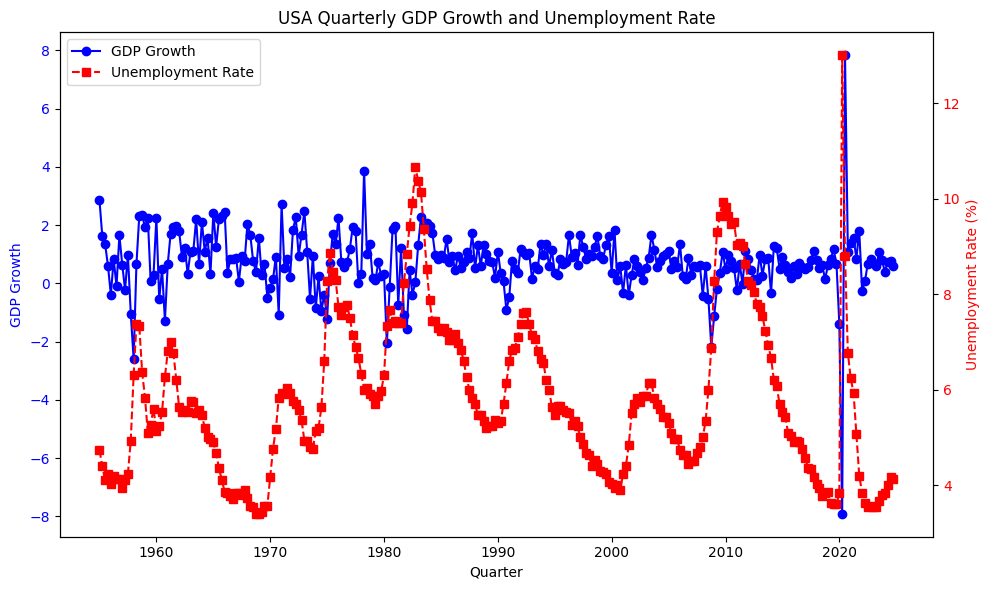

In [32]:
# Plot for a chosen country ('USA') and (optionally) specify date range:
plot_country_quarterly(df, country="USA", start_date="1955-01-01", end_date="2024-12-31")

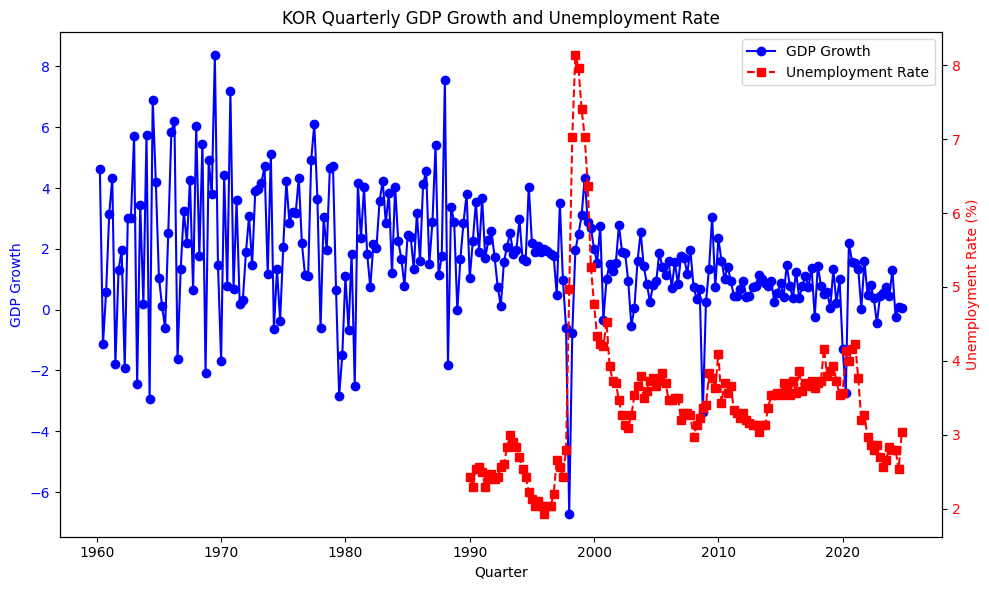

In [33]:
plot_country_quarterly(df, country="KOR", start_date="1955-01-01", end_date="2024-12-31")

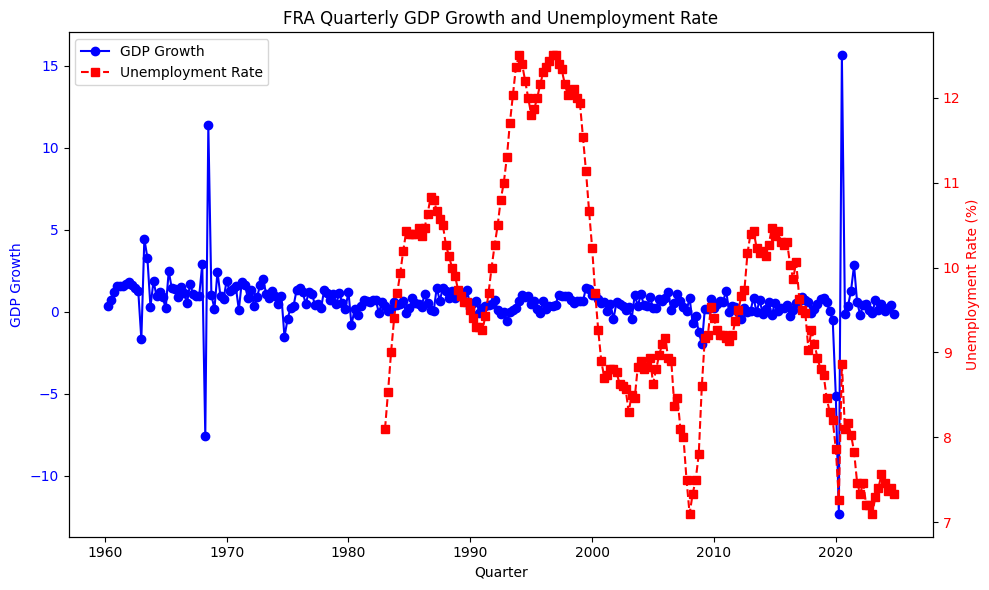

In [34]:
plot_country_quarterly(df, country="FRA", start_date="1955-01-01", end_date="2024-12-31")

In [28]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.tsatools import detrend

# --------------------------
# 1. 데이터 불러오기 및 전처리
# --------------------------
# 데이터 로드
df = pd.read_csv("../datasets/df_blanchard.csv")
print("전체 데이터 마지막 5행:")
print(df.tail())

# 분석할 국가 선택 (예: USA)
selected_country = "USA"
df_country = df[df["country"] == selected_country].copy()

# 날짜 변환 및 인덱스 설정
df_country['date'] = pd.to_datetime(df_country['date'])
df_country.set_index('date', inplace=True)
df_country.sort_index(inplace=True)

# 중복된 날짜가 있으면 제거 (asfreq 실행 전에 인덱스가 유일해야 합니다)
df_country = df_country[~df_country.index.duplicated()]

# 분기(quarterly) 데이터임을 명시적으로 설정 (Quarter Start)
df_country = df_country.asfreq('QS')

# 시간 구간 조정: 1955-01-01부터 1990-12-31까지
start_date = "1955-01-01"
end_date   = "1990-12-31"
df_sub = df_country.loc[start_date:end_date]

print(f"\n{selected_country} 데이터 기간: {df_sub.index.min()} 부터 {df_sub.index.max()} 까지")

# --------------------------
# 2. 변수 선택 및 전처리: GDP_growth와 UNEMP_rate
# --------------------------
# 이미 GDP_growth는 성장률 형태, UNEMP_rate는 비율 데이터
data = df_sub[['GDP_growth', 'UNEMP_rate']].copy()
print("\n선택된 변수 마지막 5행:")
print(data.tail())

# UNEMP_rate에 추세가 포함되어 있을 경우 간단한 선형 detrending 적용
data['UNEMP_rate'] = detrend(data['UNEMP_rate'].values, order=1)
print("\n처리된 UNEMP_rate (detrended) 마지막 5행:")
print(data.tail())

# --------------------------
# 3. VAR 모형 적합 및 시차 선택
# --------------------------
model = VAR(data)
lag_order_results = model.select_order(maxlags=8)
print("\n시차 선택 결과 (Lag Order Selection):")
print(lag_order_results.summary())

# 예시로 최적 시차를 3으로 선택 (실제 선택은 정보 기준을 참고하세요)
optimal_lag = 8
results = model.fit(optimal_lag)
print("\nVAR 모형 추정 결과:")
print(results.summary())

print("\nVAR 모형의 고유값 (Eigenvalues):")
roots = results.roots
print(roots)

# --------------------------
# 4. Stationarity Check
# --------------------------
# 정상성을 만족하려면 모든 고유값의 절대값이 1보다 작아야 합니다.
abs_roots = np.abs(roots)
max_modulus = np.max(abs_roots)
print("\n각 고유값의 절대값:", abs_roots)
print("최대 고유값 모듈러스:", max_modulus)

if np.all(abs_roots < 1):
    print("\nThe VAR system is stationary. All eigenvalues are inside the unit circle.")
else:
    print("\nThe VAR system is nonstationary. Some eigenvalues are outside the unit circle.")

# --------------------------
# 5. Granger 인과성 검정
# --------------------------
# (a) GDP_growth가 UNEMP_rate에 Granger 인과성이 있는지 Wald-test
gc_test1 = results.test_causality(caused='UNEMP_rate', causing='GDP_growth', kind='wald')
print("\nGranger 인과성 테스트: GDP_growth -> UNEMP_rate")
print(gc_test1.summary())

# (b) UNEMP_rate가 GDP_growth에 Granger 인과성이 있는지 Wald-test
gc_test2 = results.test_causality(caused='GDP_growth', causing='UNEMP_rate', kind='wald')
print("\nGranger 인과성 테스트: UNEMP_rate -> GDP_growth")
print(gc_test2.summary())


전체 데이터 마지막 5행:
     country        date  UNEMP_rate  GDP_growth
2150     GBR  2024-10-01    4.400000    0.095375
2151     ITA  2024-10-01    6.100000    0.135562
2152     JPN  2024-10-01    2.500000    0.556141
2153     KOR  2024-10-01    3.033333    0.066216
2154     USA  2024-10-01    4.133333    0.607065

USA 데이터 기간: 1955-01-01 00:00:00 부터 1990-10-01 00:00:00 까지

선택된 변수 마지막 5행:
            GDP_growth  UNEMP_rate
date                              
1989-10-01    0.196981    5.366667
1990-01-01    1.092882    5.300000
1990-04-01    0.362970    5.333333
1990-07-01    0.066582    5.700000
1990-10-01   -0.910405    6.133333

처리된 UNEMP_rate (detrended) 마지막 5행:
            GDP_growth  UNEMP_rate
date                              
1989-10-01    0.196981   -1.803421
1990-01-01    1.092882   -1.888496
1990-04-01    0.362970   -1.873571
1990-07-01    0.066582   -1.525312
1990-10-01   -0.910405   -1.110387

시차 선택 결과 (Lag Order Selection):
 VAR Order Selection (* highlights the minimums) 
      A

### 가깝지만 여전히 Non-Stationary -> HOW?

- SVAR
- VECM
- Cointegration
- Others...

## APPENDIX

### Eigenvalue, 정상성, 특성방정식, 단위원(Unit Circle), 로그 1차 차분

1. **Eigenvalue(고유값)와 정상성:**
   - VAR 모형의 안정성(stability)은 모형에 사용된 행렬들의 고유값에 의해 결정됩니다.
   - 구체적으로, 모형의 모든 고유값의 절대값이 1 미만일 경우, 모형은 정상(stationary)으로 간주됩니다.
   - 이는 VAR 모형이 장기적으로 수렴(convergence)하며, 충격(shock)이 시간이 지남에 따라 소멸됨을 의미합니다.

2. **특성방정식(Characteristic Equation):**
   - 예를 들어, VAR(2) 모형에서는 특성방정식이 다음과 같이 주어집니다:
     $$
     \left| I - \Phi(1)Z - \Phi(2)Z^{2} \right| = 0
     $$
   - 이 방정식의 해(즉, \( Z \)에 대한 해)는 모형의 동적 특성을 결정하며, 각 해의 절대값은 모형의 안정성에 직접적인 영향을 미칩니다.

3. **Unit Circle(단위원):**
   - Unit circle는 복소평면에서 반지름이 1인 원을 의미합니다.
   - VAR 모형의 안정성 판별 시, 특성방정식의 모든 고유값이 단위원 밖(즉, 절대값이 1보다 큰 영역)에 위치해야 합니다.
   - 실제로, 모형의 모든 고유값의 절대값이 1 미만이면(즉, 단위원 내부에 있으면) 모형은 정상(stationary)하지 않으며, 외부에 위치하면 정상성을 만족합니다.

4. **Log First Differencing (로그 1차 차분):**
   - 로그 1차 차분은 시계열 데이터의 각 시점 값에 로그를 취한 후, 인접한 시점 간의 차이를 계산하는 방법입니다.
   - 수식으로 표현하면, $\Delta \log X_t = \log(X_t) - \log(X_{t-1})$ 와 같이 계산되며, 이는 작은 변화에 대해 $\frac{X_t - X_{t-1}}{X_{t-1}}$ 로 근사될 수 있습니다.
   - 이 변환은 데이터의 상대적 변화, 즉 성장률 또는 비율 변화를 나타내며, 특히 경제나 금융 데이터를 분석할 때 유용합니다.
   - 로그 1차 차분은 다음과 같은 효과를 가집니다:
     - **비정상성 제거:** 수준(levels)의 시계열 데이터는 일반적으로 추세나 단위근(unit root) 문제로 인해 비정상(non-stationary)일 수 있는데, 로그 1차 차분을 통해 이러한 비정상성을 완화할 수 있습니다.
     - **분산 안정화:** 로그 변환을 사용하면 큰 값과 작은 값 사이의 스케일 차이가 줄어들어 분산이 안정화됩니다.
     - **해석 용이성:** 로그 1차 차분은 직접적으로 성장률(또는 비율 변화)을 반영하므로, 변수들 간의 상호작용이나 동적 변화를 해석하는 데 직관적인 장점을 제공합니다.
